In [1]:
# Import python packages 
import uproot 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import vector
vector.register_awkward()
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit


### Let's take on our first particle physics data analysis! 

We'll be using CMS Open Data for this exercise. This data already has a lot of processing and filtering done. The raw detector data has been resonctructed into the particles we're interested in studying. 

We'll study the Z boson decay to a muon and anti-muon pair today. We can visualize this with the Feynman diagram below: 

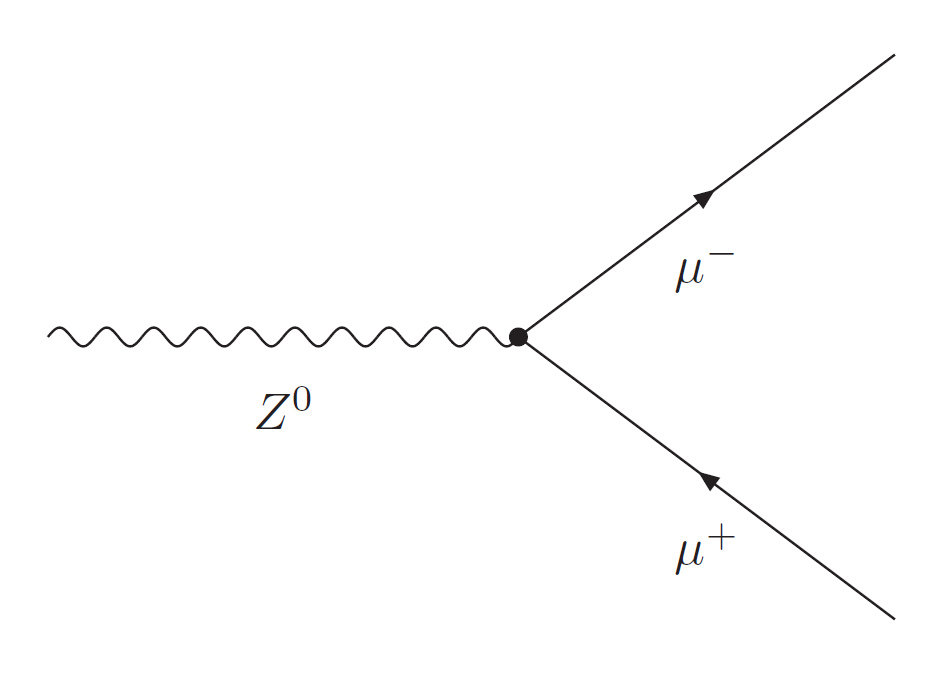 

Therefore, we only care about events with muons. So, our input dataset just contains muons. Note that in a real analysis, we probably would look at the information from many different types of particles, like electrons, photons, etc. 

#### Step 1: Load our input file and evaluate what it contains

In [2]:
# open the input file and convert it to a pandas dataframe

infile = uproot.open('uproot-tutorial-file.root') 
mydf = infile['Events'].arrays(library='awkward')

In [3]:
# print the information in this input file 
mydf.fields

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

Text(0.5, 1.0, 'Number of Muons')

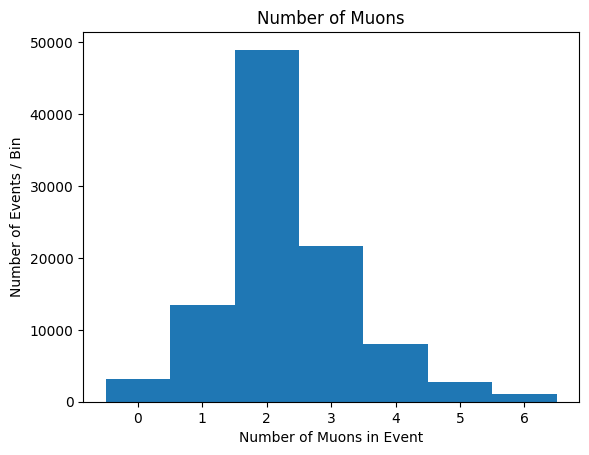

In [4]:
bins = np.linspace(-0.5,6.5,8)
plt.hist(mydf.nMuon,bins=bins)

plt.xlabel('Number of Muons in Event')
plt.ylabel('Number of Events / Bin')
plt.title('Number of Muons')

#### Step 2: Apply a "preselection" to only look at relevant events (here, those with at least two muons)

In [5]:
# now, let's only look at events with >= 2 muons 
mydf_preselection = mydf[ mydf.nMuon >= 2 ]

Text(0.5, 1.0, 'Number of Muons')

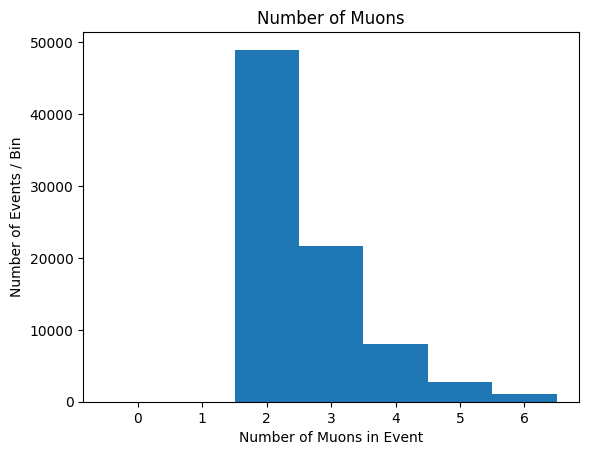

In [6]:
# plot again, just to make sure we did that right :) 

bins = np.linspace(-0.5,6.5,8)
plt.hist(mydf_preselection.nMuon,bins=bins)

plt.xlabel('Number of Muons in Event')
plt.ylabel('Number of Events / Bin')
plt.title('Number of Muons')

In [7]:
# in particle physics data analysis, we usually sort things by transverse momentum (pt), so let's do that here 

mydf_preselection = ak.sort(mydf_preselection, ascending=False)

#### Step 3: Develop a "selection" to get rid of background processes that give us two muons, while retaining the signal (Z decays) we care about 

In [8]:
# the following allows us to create lorentz vectors for the particles in our events; this is useful, since it takes care of special relativity calculations for us! 

muon_p4 = vector.zip({
    'pt': mydf_preselection['Muon_pt'], 
    'eta': mydf_preselection['Muon_eta'], 
    'phi': mydf_preselection['Muon_phi'], 
    'mass': mydf_preselection['Muon_mass'],
    'charge':mydf_preselection['Muon_charge']})

# print the pt of the muons in the events
muon_p4.pt

<Array [[15.7, 10.8], ..., [11.4, ..., 3.08]] type='83343 * var * float32'>

In [9]:
# create a new variable - the invariant mass of the leading and subleading muons 

muon1 = muon_p4[:,0]
muon2 = muon_p4[:,1]

mydf_preselection['mass_mumu'] = (muon1 + muon2).mass

In [10]:
# we are going to "blind" the region of this variable in which our Z-ll signal lives, so we don't bias ourselves 

blind_x = [75,105]

(0.0, 600.0)

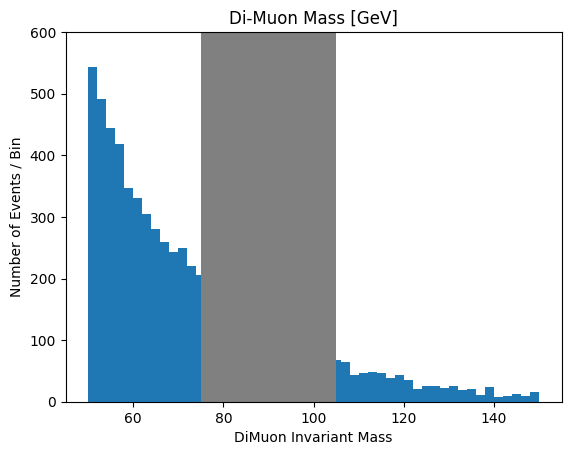

In [11]:
# let's plot this new variable

bins = np.linspace(50,150,51)
plt.hist(mydf_preselection.mass_mumu,bins=bins)

# blind our signal region 
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((blind_x[0], 0), blind_x[1]-blind_x[0], 2500, facecolor="grey"))

plt.xlabel('DiMuon Invariant Mass')
plt.ylabel('Number of Events / Bin')
plt.title('Di-Muon Mass [GeV]')
plt.ylim([0,600])

In [12]:
# now let's make another variable - whether or not the charges of the two leading muons is the same or different 

mydf_preselection['opp_charge_mumu'] = ( muon1.charge != muon2.charge )


In [13]:
# for a Z decay, we know the two muons should have opposite charges, so let's use this as a selection 

mydf_selection = mydf_preselection[ mydf_preselection['opp_charge_mumu']==True ]

(0.0, 600.0)

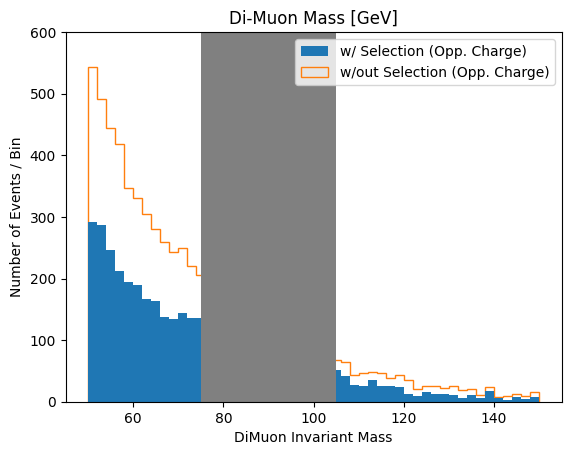

In [14]:
# let's plot the di-muon invariant mass again, but now with this selection applied 

plt.hist(mydf_selection.mass_mumu,bins=bins,label='w/ Selection (Opp. Charge)')
plt.hist(mydf_preselection.mass_mumu,bins=bins,histtype='step',label='w/out Selection (Opp. Charge)',zorder=0)

# blind our signal region 
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((blind_x[0], 0), blind_x[1]-blind_x[0], 2500, facecolor="grey"))

plt.xlabel('DiMuon Invariant Mass')
plt.ylabel('Number of Events / Bin')
plt.title('Di-Muon Mass [GeV]')
plt.legend()
plt.ylim([0,600])

#### Step 4: Perform a statisitcal analysis. 

This is *heavily simplified* - we're just going to fit our background with an analytic function in the unblinded region, then interpolate into the signal region to get an estimate of the number of background events in that region. We can then look in the signal region and subtract out our estimated background, leaving us with only the signal yield. 

In [15]:
from scipy.optimize import curve_fit

def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

def exponential(x, normalization, c, offset):
    return normalization*np.exp(-c*x)+offset

In [16]:
# create arrays of x and y values for us to fit (only in the blinded region) 

bin_values = np.histogram( mydf_selection.mass_mumu , bins=bins )[0]
bin_centers = np.array([ 0.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1) ])

blind_mask = (bin_centers<blind_x[0])|(bin_centers>=blind_x[1])

bin_values = bin_values[ blind_mask ]
bin_centers = bin_centers[ blind_mask ]

In [17]:
# fit the background with a falling exponential function 

popt, pcov = curve_fit(exponential, bin_centers, bin_values, p0=[250,0.2,10])

# print fitted funciton paramters 
popt

/var/folders/7h/tbsx4dl56c573830frx6wgrcy39g7m/T/ipykernel_30219/3314950485.py:9: RuntimeWarning: overflow encountered in exp
  return normalization*np.exp(-c*x)+offset


array([2.22752602e+03, 4.02519682e-02, 1.61668885e+00])

(0.0, 600.0)

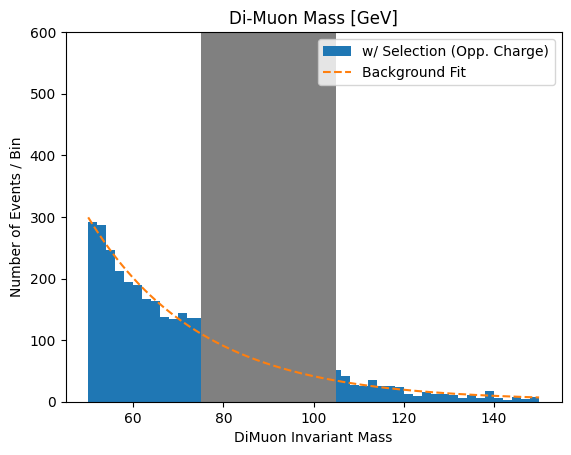

In [18]:
# make a plot including our fitted background function 

plt.hist(mydf_selection.mass_mumu,bins=bins,label='w/ Selection (Opp. Charge)')

xfit = np.linspace(bins[0],bins[-1],1000)
yfit = exponential(xfit, popt[0], popt[1], popt[2] )
plt.plot(xfit, yfit, linestyle='--', label='Background Fit')


# blind our signal region 
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((blind_x[0], 0), blind_x[1]-blind_x[0], 2500, facecolor="grey"))

plt.xlabel('DiMuon Invariant Mass')
plt.ylabel('Number of Events / Bin')
plt.title('Di-Muon Mass [GeV]')
plt.legend()
plt.ylim([0,600])

In [26]:
# let's use our exponential function to predict how much background we have in the blinded signal region 

bin_centers = np.array([ 0.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1) ])
# now select only the signal region
blind_mask = (bin_centers>=blind_x[0])&(bin_centers<blind_x[1])
bin_centers = bin_centers[blind_mask]

est_background_bin_contents = exponential( bin_centers, popt[0] , popt[1] , popt[2] )
est_N_background = est_background_bin_contents.sum()
est_N_background 

1010.6271552318642

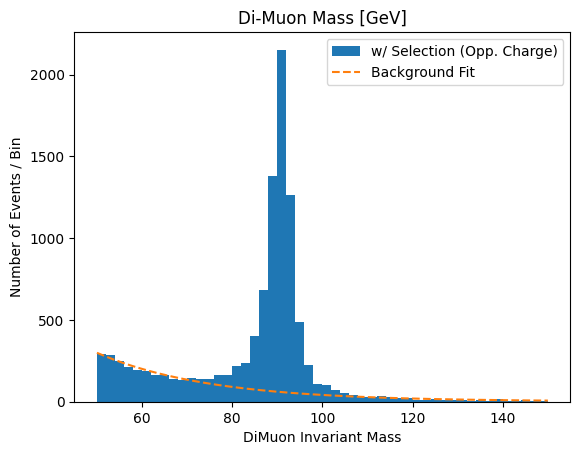

In [27]:
# now let's unblind! 

plt.hist(mydf_selection.mass_mumu,bins=bins,label='w/ Selection (Opp. Charge)')

xfit = np.linspace(bins[0],bins[-1],1000)
yfit = exponential(xfit, popt[0], popt[1], popt[2] )
plt.plot(xfit, yfit, linestyle='--', label='Background Fit')

plt.xlabel('DiMuon Invariant Mass')
plt.ylabel('Number of Events / Bin')
plt.title('Di-Muon Mass [GeV]')
plt.legend()


In [28]:
# let's calculate how much signal was in our signal region by subtracting out the fitted background yield in that region 

bin_values = np.histogram( mydf_selection.mass_mumu , bins=bins )[0]
bin_centers = np.array([ 0.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1) ])

# now select only the signal region
blind_mask = (bin_centers>=blind_x[0])&(bin_centers<blind_x[1])

bin_values = bin_values[ blind_mask ]

N_signalregion = np.sum( bin_values )
N_signalregion

7786.0

In [29]:
est_N_signal = N_signalregion - est_N_background

est_N_signal

6775.372844768136

We would want to compare this number with our theoretical predictions! That requires calculating cross sections, which you have done in this class :) 